# Calculate the probability of Illinois drivers' age given race 

The python file should do the following:
- Calculate Pr(age|race). 
- Given race, draw the age distribution curve
- Draw the spline on the curve

We will do them one by one.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/"

In [4]:
sos_data = pd.read_csv(path + "processed_sos.csv")
census_age = pd.read_csv(path+"census_age.csv") # this is actually from ACS
census_race = pd.read_csv(path+"census_race.csv") # ACS too

## Cleaning Census Chicago residents age data
Data is downloaded [**here**](https://data.census.gov/cedsci/table?q=chicago%20race%20age%20sex&tid=ACSST1Y2021.S0101)

In [5]:
acs_age = pd.read_excel(path+"acs21_age.xlsx", sheet_name = "Data", usecols = "A:B,D", skiprows = lambda x: x in [0, 1,2,3])
acs_age = acs_age.iloc[3:17,:]
acs_age.columns = ["age_group", "estimate", "perc (%)"]
acs_age.head(5)

,age_group,estimate,perc (%)
3,15 to 19 years,"147,958",5.5%
4,20 to 24 years,"188,295",7.0%
5,25 to 29 years,"269,990",10.0%
6,30 to 34 years,"248,720",9.2%
7,35 to 39 years,"215,854",8.0%


In [ ]:
acs_age.dtypes

age_group     object
estimate       int64
perc (%)     float64
dtype: object

In [6]:
def remove_comma(df):
  """
  Removing comma from a string. The method is only restricted to the census dataset (acs_age etc).
  The function loops through each string, splits it by the comma in between, and rejoins the string.
    For example, the process looks like "5,6000" -> ["5", "600"], "5600" 
  -----

  Input: df, 
        a census dataset where the string number is in the second column
  -----
  Output: df, 
        a cleaned dataset where all numbers do not have (a) comma(s) in between   
  """

  for i in range(df.shape[0]):
    vals = df.iloc[i,1].split(",")
    if len(vals) >1:
      val1, val2 = vals
      val = val1 + val2
      df.iloc[i,1] = int(val)
  return df

In [7]:
def remove_perc(df):
  """
  Removing percentage from a string. The method is only restricted to the census dataset (acs_age etc).
  The function loops through each string and removes the percentage sign.
    For example, the process looks like "70%" -> "70" 
  -----

  Input: df, 
        a census dataset where the pecentage string locates in the last column
  -----
  Output: df, 
        a cleaned dataset where all numbers do not have percentage at the end   
  """
  for i in range(df.shape[0]):
    df.iloc[i, -1] = df.iloc[i, -1][:-1]
  return df

In [8]:
acs21_age = remove_comma(acs_age)  
acs21_age = remove_perc(acs_age)

In [9]:
acs_age = acs_age.astype({"estimate": "int", "perc (%)":"float"})
acs_age = acs_age.reset_index().iloc[:,1:]
acs_age.head(5)

,age_group,estimate,perc (%)
0,15 to 19 years,147958,5.5
1,20 to 24 years,188295,7.0
2,25 to 29 years,269990,10.0
3,30 to 34 years,248720,9.2
4,35 to 39 years,215854,8.0


In [10]:
def subtract_age_range(df):
  """
  Subtract age ranges from a dataset. 
   
  -----

  Input: df, 
        a census dataset where age ranges are in the first column
  -----
  Output: df, 
        a cleaned dataset where age range follows the format of "lowrange-highrange" 
      age_list,
        the name of all age ranges (a list of tuples)
  """
  age_lst = []
  for i in range(df.shape[0]):
    range_lst = df.iloc[i,0].split()
    low = range_lst[0]
    max = range_lst[2]
    age_tuple = (low, max)
    age_lst.append(age_tuple)
    df.iloc[i,0] = low+ "-" + max
  return df, age_lst
acs_age, acs21_age_lst = subtract_age_range(acs_age)
acs_age.head(5)

,age_group,estimate,perc (%)
0,15-19,147958,5.5
1,20-24,188295,7.0
2,25-29,269990,10.0
3,30-34,248720,9.2
4,35-39,215854,8.0


In [11]:
acs21_age_lst

[('15', '19'),
 ('20', '24'),
 ('25', '29'),
 ('30', '34'),
 ('35', '39'),
 ('40', '44'),
 ('45', '49'),
 ('50', '54'),
 ('55', '59'),
 ('60', '64'),
 ('65', '69'),
 ('70', '74'),
 ('75', '79'),
 ('80', '84')]

In [12]:
acs_age.loc[:,'rel_perc (%)'] = acs_age.loc[:, "perc (%)"]/acs_age.loc[:, "perc (%)"].sum()*100
acs_age.loc[:,'rel_perc (%)'] = acs_age.loc[:,'rel_perc (%)'].apply(lambda x: round(x,2))
acs_age.head(5)

,age_group,estimate,perc (%),rel_perc (%)
0,15-19,147958,5.5,6.72
1,20-24,188295,7.0,8.56
2,25-29,269990,10.0,12.22
3,30-34,248720,9.2,11.25
4,35-39,215854,8.0,9.78


In [ ]:
acs_age.head(5)

,age_group,estimate,perc (%),rel_perc (%)
0,15-19,147958,5.5,6.72
1,20-24,188295,7.0,8.56
2,25-29,269990,10.0,12.22
3,30-34,248720,9.2,11.25
4,35-39,215854,8.0,9.78


## Cleaning Census Chicago residents race data
Data is downloaded [**here**](https://data.census.gov/cedsci/table?q=chicago%20race)

***Problem:*** birace or multirace population: how to count them? (simply adding would result in overlapping)

In [13]:
acs21_race = pd.read_excel(path+"acs21_race.xlsx", sheet_name = "Data", usecols = "A:B,D", skiprows = lambda x: x in [0, 1,2,3])
acs21_race = acs21_race.iloc[0:6,:]
acs21_race.columns = ["race", "estimate"]
acs21_race

/usr/local/lib/python3.7/dist-packages/pandas/io/excel/_base.py:1292: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  **kwds,


,race,estimate
0,White alone,"863,622"
1,Black or African American alone,"787,551"
2,American Indian and Alaska Native alone,"3,332"
3,Asian alone,"189,857"
4,Native Hawaiian and Other Pacific Islander alone,529
5,Some Other Race alone,"11,536"


In [14]:
acs21_race.race = ['White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race']
acs21_race

,race,estimate
0,White,"863,622"
1,Black or African American,"787,551"
2,American Indian and Alaska Native,"3,332"
3,Asian,"189,857"
4,Native Hawaiian and Other Pacific Islander,529
5,Some other race,"11,536"


In [15]:
acs21_race = remove_comma(acs21_race)
acs21_race = acs21_race.astype({"estimate": "int"})
#acs21_race.dtypes

In [16]:
acs21_race.loc[:, "perc (%)"] = acs21_race.estimate/acs21_race.estimate.sum()*100

In [17]:
acs21_race.loc[:, "perc (%)"] = acs21_race.loc[:, "perc (%)"].apply(lambda x: round(x, 2))

In [ ]:
acs21_race.dtypes

race         object
estimate      int64
perc (%)    float64
dtype: object

In [18]:
acs21_race

,race,estimate,perc (%)
0,White,863622,46.52
1,Black or African American,787551,42.42
2,American Indian and Alaska Native,3332,0.18
3,Asian,189857,10.23
4,Native Hawaiian and Other Pacific Islander,529,0.03
5,Some other race,11536,0.62


### Loading the ACS data

In [19]:
acs_data = census_age.merge(census_race, how = "left", on = "Block Group" )
acs_data.head(5)

,Block Group,Total:_x,All: Under 5 years,All: 5 to 9 years,All: 10 to 14 years,All: 15 to 17 years,All: 18 and 19 years,All: 20 years,All: 21 years,All: 22 to 24 years,...,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Two or more races,Hispanic or Latino,BG_Block_Group_num_y,BG_Census Tract_y,BG_County_y,BG_State_y
0,"Block Group 1, Census Tract 3018.01, Cook Coun...",1933,396,82,312,59,45,0,0,75,...,0,0,0,0,14,1886,1,3018.01,Cook County,Illinois
1,"Block Group 2, Census Tract 3018.02, Cook Coun...",1238,26,193,155,90,59,24,21,36,...,0,0,0,0,0,1191,2,3018.02,Cook County,Illinois
2,"Block Group 2, Census Tract 3018.03, Cook Coun...",1606,147,131,92,15,0,23,0,102,...,0,0,0,0,0,1606,2,3018.03,Cook County,Illinois
3,"Block Group 2, Census Tract 3102, Cook County,...",1009,83,40,31,14,0,0,0,23,...,0,135,0,0,6,445,2,3102.00,Cook County,Illinois
4,"Block Group 1, Census Tract 3105, Cook County,...",1434,107,70,86,22,16,0,17,109,...,0,7,0,0,0,1148,1,3105.00,Cook County,Illinois


In [ ]:
acs_data.iloc[:, [5,6]].sum()

All: 15 to 17 years     188610
All: 18 and 19 years    121506
dtype: int64

In [ ]:
acs_data.columns

Index(['Block Group', 'Total:_x', 'All: Under 5 years', 'All: 5 to 9 years',
       'All: 10 to 14 years', 'All: 15 to 17 years', 'All: 18 and 19 years',
       'All: 20 years', 'All: 21 years', 'All: 22 to 24 years',
       'All: 25 to 29 years', 'All: 30 to 34 years', 'All: 35 to 39 years',
       'All: 40 to 44 years', 'All: 45 to 49 years', 'All: 50 to 54 years',
       'All: 55 to 59 years', 'All: 60 and 61 years', 'All: 62 to 64 years',
       'All: 65 and 66 years', 'All: 67 to 69 years', 'All: 70 to 74 years',
       'All: 75 to 79 years', 'All: 80 to 84 years', 'All: 85 years and over',
       'BG_Block_Group_num_x', 'BG_Census Tract_x', 'BG_County_x',
       'BG_State_x', 'Total:_y', 'Not Hispanic or Latino', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Two or more races', 'Hispanic or Latino',
       'BG_Block_Group_num_y', 'BG_Census Tract_y', 'BG_Co

## Getting Age by Race data from the Census

Data can be downloaded below
- [**White**](https://data.census.gov/cedsci/table?q=chicago%20age%20white)
- [**Black**](https://data.census.gov/cedsci/table?q=chicago%20age%20black)
- [**American Indian**](https://data.census.gov/cedsci/table?q=B01001C,%20Chicago)
- [**Asian**](https://data.census.gov/cedsci/table?q=chicago%20age%20asian)
- [**Pacific Islanders**](https://data.census.gov/cedsci/table?q=B01001E,%20Chicago)
- [**Some Other Races**](https://data.census.gov/cedsci/table?q=B01001F,%20Chicago)


#### Step 1: Creating new `age_group` Dataframe 
(so that the naming convention is consistent) 

First, we notice there is a name discrepancy in the `age_group` column in our *census21_age* dataframe and the new one (Census B01001X (x is a uppercase letter) tables). We followed the latter's naming convention and created a new dataframe named *acs21_age*

In [20]:
lst35_44 = ["35-44"] + [x for x in (acs_age.iloc[4,1:] + acs_age.iloc[5,1:]).values]
lst45_54 = ["45-54"] + [x for x in (acs_age.iloc[6,1:] + acs_age.iloc[7,1:]).values]
lst55_64 = ["55-64"] + [x for x in (acs_age.iloc[8,1:] + acs_age.iloc[9,1:]).values]
lst65_74 = ["65-74"] + [x for x in (acs_age.iloc[10,1:] + acs_age.iloc[11,1:]).values]
lst75_84 = ["75-84"] + [x for x in (acs_age.iloc[12,1:] + acs_age.iloc[13,1:]).values]

large_agegroup = [lst35_44, lst45_54, lst55_64, lst65_74, lst75_84]

In [21]:
def create_new_age():
  """
  Create new age groups so that age groups are consistent across different dataset. 
  The age groups are: 
     15-19 (merge two different ACS groups)
     20-24
     25-29,
     30-34,
     35-44, (from below, merge a few census groups)
     45-54,
     55-64,
     65-74,
     75-84 
  -----

  Input: none

  -----
  Output: df, 
        a cleaned dataset where the `age_group` column uses standardized age groups
  """
  new_age = acs_age.iloc[:4,:]
  for i in range(len(large_agegroup)):
    dic = {}
    for ind, val in enumerate(acs_age.columns):
      dic[val] = large_agegroup[i][ind]
    new_age = new_age.append(dic, ignore_index=True)
  return new_age

In [22]:
acs21_age = create_new_age()  # probably either one should have a different name
acs21_age

,age_group,estimate,perc (%),rel_perc (%)
0,15-19,147958,5.5,6.72
1,20-24,188295,7.0,8.56
2,25-29,269990,10.0,12.22
3,30-34,248720,9.2,11.25
4,35-44,401679,14.9,18.22
5,45-54,311218,11.6,14.18
6,55-64,302247,11.2,13.69
7,65-74,223266,8.3,10.14
8,75-84,110251,4.1,5.02


In [ ]:
# 15-17, 18-19 ---> 15-19
# 35-44 ---> 35-39, 40-44 
# 45-54 --> 45-49, 50-54
# 55-64 --> 55-59, 60-64
# 65-74 --> 65-69, 70-74
# 75-84 --> 75-79, 80-84

['White', 'White', 'White', 'White', 'White']

In [ ]:
# acs21_race.race.unique()

array(['White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian',
       'Native Hawaiian and Other Pacific Islander', 'Some other race'],
      dtype=object)

#### Step 2: Create Age by Race Dataframe

In [23]:
age_group = acs21_age.age_group.unique()
age_num = len(age_group)
whites_age = {"race": ["White"]*age_num,
              "age_group": age_group,
              "estimate":[10124 + 8715+ 9205 + 9356, 28273+34665 , 58508+58445,
                          55690 + 55934, 86185 + 77062, 55305 + 50995, 55374 + 52303,
                          39355 + 46285, 18525+ 23547]}

In [24]:
acs21_age_race= pd.DataFrame(whites_age)
#acs21_age_race

In [25]:
black_age =  {"race": ["Black or African American"]*age_num,
              "age_group": age_group,
              "estimate":[13866+ 14565+ 8420+ 7155, 23820+27242, 32260+33072, 
                          25594+29300, 42629+53932, 38764+49238, 44746+57642,
                          28694+46391, 13677+23365]}
acs21_age_race = acs21_age_race.append(pd.DataFrame(black_age), ignore_index=True)
#acs21_age_race

In [26]:
ameri_indian_age =  {"race": ["American Indian and Alaska Native"]*age_num,
              "age_group": age_group,
              "estimate":[1020 + 1763+ 537 + 615, 1098+ 855, 712 + 780,
                          1454+1336,3183+2488,2160+1944,1379+1113,
                          320+617, 423 + 442]} 
                         
acs21_age_race = acs21_age_race.append(pd.DataFrame(ameri_indian_age), ignore_index=True)
#acs21_age_race 

In [27]:
asian_age =  {"race": ["Asian"]*age_num,
              "age_group": age_group,
              "estimate":[1753+ 1678+ 2017 + 1801, 6867+7542, 10968+10678,
                          11775 + 12326, 15497 + 15933, 10623 + 10069, 7942 + 9973,
                          6235 + 7680, 3969+4246]}  

acs21_age_race = acs21_age_race.append(pd.DataFrame(asian_age), ignore_index=True)
#acs21_age_race 

In [28]:
pacific_age =  {"race": ["Native Hawaiian and Other Pacific Islander"]*age_num,
              "age_group": age_group,
              "estimate":[83 + 19+ 35 + 16,8 + 33, 55+ 15,
                          111 + 37, 110+ 107, 72+ 86 ,0 +18, 
                          17+2, 18+ 5]}  
                        
acs21_age_race = acs21_age_race.append(pd.DataFrame(pacific_age), ignore_index=True)
#acs21_age_race 

In [29]:
otherrace_age =  {"race": ["Some other race"]*age_num,
              "age_group": age_group,
              "estimate":[9960 + 7101+ 7140 +4986, 12707 + 16103, 15076+ 16245,
                          13937 + 11601, 26170+ 24517,22792 + 23551,19217 + 18235,
                         12492 +10688 , 3206 + 5426 ]}  

acs21_age_race = acs21_age_race.append(pd.DataFrame(otherrace_age), ignore_index=True)
#acs21_age_race.head(5) 

In [ ]:
acs21_age_race.head(5)

,race,age_group,estimate
0,White,15-19,37400
1,White,20-24,62938
2,White,25-29,116953
3,White,30-34,111624
4,White,35-44,163247


In [51]:
acs21_age_race.loc[:,"Perc (%)"] = acs21_age_race.iloc[:,2]/acs21_age_race.iloc[:,2].sum()
acs21_age_race.iloc[:,-1] = acs21_age_race.iloc[:,-1].apply(lambda x: round(x, 6))
acs21_age_race.head(5)

,race,age_group,estimate,Perc (%)
0,White,15-19,37400,0.019540
1,White,20-24,62938,0.032882
2,White,25-29,116953,0.061103
3,White,30-34,111624,0.058319
4,White,35-44,163247,0.085290


In [52]:
acs21_age_race.to_csv(path+"race_conditioned_age_probability.csv", index=False)

### Step 3: Calculating Aggregated Counts by Race




In [31]:
acs21_race_agg = acs21_age_race.groupby("race").aggregate(sum)  
#acs21_race_agg.iloc[:,-1] = acs21_race_agg.iloc[:,-1].apply(lambda x: round(x, 4))
#acs21_race_agg

In [32]:
acs21_race_agg = acs21_race_agg.reset_index()
acs21_race_agg

,race,estimate,Perc (%)
0,American Indian and Alaska Native,24239,0.0128
1,Asian,159572,0.0834
2,Black or African American,614372,0.3210
3,Native Hawaiian and Other Pacific Islander,847,0.0004
4,Some other race,281150,0.1469
5,White,833851,0.4356


### Step 4: Calculating Aggregated Counts by Age


In [34]:
census21_age_agg = acs21_age_race.groupby("age_group").aggregate(sum)  
#census21_age_agg.iloc[:,-1] = acs21_race_agg.iloc[:,-1].apply(lambda x: round(x, 4))
#census21_age_agg

In [35]:
census21_age_agg = census21_age_agg.reset_index()
census21_age_agg

,age_group,estimate,Perc (%)
0,15-19,121930,0.0637
1,20-24,159213,0.0832
2,25-29,236814,0.1237
3,30-34,219095,0.1145
4,35-44,347813,0.1817
5,45-54,265599,0.1387
6,55-64,267942,0.1401
7,65-74,198776,0.1038
8,75-84,96849,0.0507


## Getting from ACS data - A Comparative View

In [36]:
acs_data = census_age.merge(census_race, how = "left", on = "Block Group" )
acs_data.head(5)

,Block Group,Total:_x,All: Under 5 years,All: 5 to 9 years,All: 10 to 14 years,All: 15 to 17 years,All: 18 and 19 years,All: 20 years,All: 21 years,All: 22 to 24 years,...,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Two or more races,Hispanic or Latino,BG_Block_Group_num_y,BG_Census Tract_y,BG_County_y,BG_State_y
0,"Block Group 1, Census Tract 3018.01, Cook Coun...",1933,396,82,312,59,45,0,0,75,...,0,0,0,0,14,1886,1,3018.01,Cook County,Illinois
1,"Block Group 2, Census Tract 3018.02, Cook Coun...",1238,26,193,155,90,59,24,21,36,...,0,0,0,0,0,1191,2,3018.02,Cook County,Illinois
2,"Block Group 2, Census Tract 3018.03, Cook Coun...",1606,147,131,92,15,0,23,0,102,...,0,0,0,0,0,1606,2,3018.03,Cook County,Illinois
3,"Block Group 2, Census Tract 3102, Cook County,...",1009,83,40,31,14,0,0,0,23,...,0,135,0,0,6,445,2,3102.00,Cook County,Illinois
4,"Block Group 1, Census Tract 3105, Cook County,...",1434,107,70,86,22,16,0,17,109,...,0,7,0,0,0,1148,1,3105.00,Cook County,Illinois


In [ ]:
acs_data.iloc[:, [5,6]].sum()

All: 15 to 17 years     188610
All: 18 and 19 years    121506
dtype: int64

In [ ]:
acs_data.columns

Index(['Block Group', 'Total:_x', 'All: Under 5 years', 'All: 5 to 9 years',
       'All: 10 to 14 years', 'All: 15 to 17 years', 'All: 18 and 19 years',
       'All: 20 years', 'All: 21 years', 'All: 22 to 24 years',
       'All: 25 to 29 years', 'All: 30 to 34 years', 'All: 35 to 39 years',
       'All: 40 to 44 years', 'All: 45 to 49 years', 'All: 50 to 54 years',
       'All: 55 to 59 years', 'All: 60 and 61 years', 'All: 62 to 64 years',
       'All: 65 and 66 years', 'All: 67 to 69 years', 'All: 70 to 74 years',
       'All: 75 to 79 years', 'All: 80 to 84 years', 'All: 85 years and over',
       'BG_Block_Group_num_x', 'BG_Census Tract_x', 'BG_County_x',
       'BG_State_x', 'Total:_y', 'Not Hispanic or Latino', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Two or more races', 'Hispanic or Latino',
       'BG_Block_Group_num_y', 'BG_Census Tract_y', 'BG_Co

### ACS age group estimates

In [37]:
age5 = sum(acs_data.loc[:,"All: Under 5 years"])
age5_9 =  sum(acs_data.loc[:,"All: 5 to 9 years"])
age10_14 =  sum(acs_data.loc[:,"All: 10 to 14 years"])
age15_17 =  sum(acs_data.loc[:,"All: 15 to 17 years"])
age18_19 =  sum(acs_data.loc[:,"All: 18 and 19 years"])
age20  =  sum(acs_data.loc[:,"All: 20 years"])
age21 =  sum(acs_data.loc[:,"All: 21 years"])
age22_24 =  sum(acs_data.loc[:,"All: 22 to 24 years"])
age25_29 =   sum(acs_data.loc[:,"All: 25 to 29 years"])
age30_34=  sum(acs_data.loc[:,"All: 30 to 34 years"])
age35_39 = sum(acs_data.loc[:,"All: 35 to 39 years"])
age40_44 = sum(acs_data.loc[:,"All: 40 to 44 years"])
age45_49 = sum(acs_data.loc[:,"All: 45 to 49 years"])
age50_54 = sum(acs_data.loc[:,"All: 50 to 54 years"])
age55_59 = sum(acs_data.loc[:,"All: 55 to 59 years"])
age60_61 = sum(acs_data.loc[:,"All: 60 and 61 years"])
age62_64 = sum(acs_data.loc[:,"All: 62 to 64 years"])
age65_66 =  sum(acs_data.loc[:,"All: 65 and 66 years"])
age67_69 = sum(acs_data.loc[:,"All: 67 to 69 years"])
age70_74 = sum(acs_data.loc[:,"All: 70 to 74 years"])
age75_79 = sum(acs_data.loc[:,"All: 75 to 79 years"])
age80_84 = sum(acs_data.loc[:,"All: 80 to 84 years"])
age85 = sum(acs_data.loc[:,"All: 85 years and over"])

In [38]:
acs21_age.age_group.unique()

array(['15-19', '20-24', '25-29', '30-34', '35-44', '45-54', '55-64',
       '65-74', '75-84'], dtype=object)

In [39]:
acs_age_dic = {
    "age_group": acs21_age.age_group.unique(),
    "estimate (ACS)": [age15_17 + age18_19, age20+age21+age22_24, age25_29, age30_34,
                 age35_39 + age40_44, age45_49+age50_54, age55_59+age60_61+age62_64,
                 age65_66+age67_69+age70_74, age75_79+age80_84]
}

acs_age_agg = pd.DataFrame(acs_age_dic)
acs_age_agg.head(5)

,age_group,estimate (ACS)
0,15-19,310116
1,20-24,334453
2,25-29,432731
3,30-34,412096
4,35-44,699725


In [40]:
acs_age_agg["perc (ACS)"] = acs_age_agg.iloc[:,1]/acs_age_agg.iloc[:,1].sum()
acs_age_agg.head(5)

,age_group,estimate (ACS),perc (ACS)
0,15-19,310116,0.075174
1,20-24,334453,0.081073
2,25-29,432731,0.104897
3,30-34,412096,0.099895
4,35-44,699725,0.169618


### Join Two Aggregated Age Tables

In [41]:
age_agg = pd.concat([census21_age_agg, acs_age_agg], axis=1)
age_agg

,age_group,estimate,Perc (%),age_group,estimate (ACS),perc (ACS)
0,15-19,121930,0.0637,15-19,310116,0.075174
1,20-24,159213,0.0832,20-24,334453,0.081073
2,25-29,236814,0.1237,25-29,432731,0.104897
3,30-34,219095,0.1145,30-34,412096,0.099895
4,35-44,347813,0.1817,35-44,699725,0.169618
5,45-54,265599,0.1387,45-54,647738,0.157016
6,55-64,267942,0.1401,55-64,634955,0.153917
7,65-74,198776,0.1038,65-74,433863,0.105171
8,75-84,96849,0.0507,75-84,219634,0.053241


In [42]:
age_agg = age_agg.iloc[:, [x for x in range(6) if x != 3]]
age_agg = age_agg.rename(columns = {"estimate":"estimate (census)", "Perc (%)": "perc (census)"})

age_agg.head(5)

,age_group,estimate (census),perc (census),estimate (ACS),perc (ACS)
0,15-19,121930,0.0637,310116,0.075174
1,20-24,159213,0.0832,334453,0.081073
2,25-29,236814,0.1237,432731,0.104897
3,30-34,219095,0.1145,412096,0.099895
4,35-44,347813,0.1817,699725,0.169618


In [44]:
age_agg.to_csv(path+"joined_age_estimates.csv", index=False)

### ACS race estimates

In [45]:
total_white = sum(acs_data.loc[:,"White"])
total_black = sum(acs_data.loc[:,"Black or African American"])
total_asian = sum(acs_data.loc[:, "Asian"])
total_americanindian = sum(acs_data.loc[:, "American Indian and Alaska Native"])
total_pacific = sum(acs_data.loc[:, "Native Hawaiian and Other Pacific Islander"])
total_hispanic = sum(acs_data.loc[:, "Hispanic or Latino"])
total_other = sum(acs_data.loc[:, "Some other race"])

In [46]:
race_agg = pd.concat([acs21_race_agg, pd.DataFrame({"estimate (ACS)" :[total_americanindian, total_asian, total_black, 
                                                            total_pacific, total_other, total_white]})],
          axis = 1)
race_agg = race_agg.rename(columns = {"estimate":"estimate (census)", "Perc (%)": "perc (census)"})
race_agg["perc (ACS)"] = race_agg.iloc[:,3]/race_agg.iloc[:,3].sum()
race_agg.iloc[:,-1] = race_agg.iloc[:,-1].apply(lambda x: round(x, 4))
race_agg

,race,estimate (census),perc (census),estimate (ACS),perc (ACS)
0,American Indian and Alaska Native,24239,0.0128,4646,0.0012
1,Asian,159572,0.0834,382075,0.1018
2,Black or African American,614372,0.3210,1184373,0.3155
3,Native Hawaiian and Other Pacific Islander,847,0.0004,1040,0.0003
4,Some other race,281150,0.1469,12912,0.0034
5,White,833851,0.4356,2168964,0.5778


In [47]:
race_agg.to_csv(path+"joined_race_estimates.csv", index=False)

## Deliverables


### 1. Determining Pr(age|race)

We can roughly calculate the probably of age given race as the division of a joint probability over the probability of race alone. That is, $P(age|race) = \frac{P(age \cup race)}{P(race)}$

**Note:** (The reference material seems to confuse $P(age|race) \neq P(age \cup race)$ as one. These two are yet two distinct concepts.) 

> "The second quantity needed was 𝑃𝑟(𝐴𝑔𝑒|𝑅𝑎𝑐𝑒). This was estimated by smoothing the estimated age distributions in Illinois for each racial group separately." (p.38)


In [53]:
def prob_age_given_race(race, age_group, use_acs = True):
  """
  Calculate the probability of age given a race P(age|race)

  ------------------
  Input:
    race (str): 
          a race group of interest. The race group must match exactly the name of ACS
    age_group (str): 
          an age group of interest. The age group must match exactly the name of ACS
    use_acs (boolean):
          if or not to use ACS estimates of the race proprotion, default to true. If false, use Census estiamtes instead.

  -------------------------------
  Output:
    p (float): The conditional probability of age given race 
  """
  if use_acs:
    p_race = race_agg[race_agg['race'] == race].iloc[:,-1]
  else:
    p_race = race_agg[race_agg['race'] == race].iloc[:,-3]

  p_age_race = acs21_age_race[(acs21_age_race['race'] == race) & (acs21_age_race['age_group'] == age_group)].iloc[:,-1]

  p = p_age_race.item()/p_race.item() # use .item() to convert a numpy float to Python float
  return p

In [54]:
prob_age_given_race("Asian", "30-34")

0.12369351669941062

In [55]:
def prob_age_race_table():
  """
  Produce a race-condtitioned  age probability table
  --- 
  
  Input: none

  ---
  Output: printed probability table
  """

  race_lst = acs21_age_race.race.unique()
  age_lst = acs21_age_race.age_group.unique()

  for race in race_lst:
    for age in age_lst:
      p = prob_age_given_race(race, age)
      print(f"For an Illinois resident who self-identify as a(n) {race}, \n the probability of this resident in age range {age} is {round(p*100, 2)} %.")

prob_age_race_table()

For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 15-19 is 3.38 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 20-24 is 5.69 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 25-29 is 10.58 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 30-34 is 10.09 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 35-44 is 14.76 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 45-54 is 9.61 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 55-64 is 9.74 %.
For an Illinois resident who self-identify as a(n) White, 
 the probability of this resident in age range 65-74 is 7.74 %.
For an Illino

### 2. Visualizations

[Text(0, 0, '0.0%'),
 Text(0, 0, '1.0%'),
 Text(0, 0, '2.0%'),
 Text(0, 0, '3.0%'),
 Text(0, 0, '4.0%'),
 Text(0, 0, '5.0%'),
 Text(0, 0, '6.0%')]

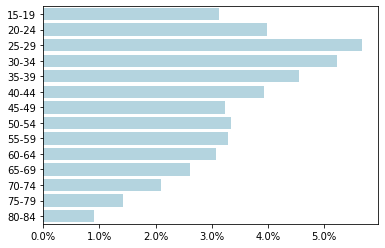

In [ ]:
age_group = acs21_age.age_group.unique()
#p = prob_age_given_race(race, age, relative_perc = True)
ax = sns.barplot(y = age_group, x = [prob_age_given_race("White", age) for age in age_group], color = "lightblue")
#plt.tlabel('Probability (%)')
vals = ax.get_xticks()
ax.set_xticklabels([str(y) + "%" for y in vals])

In [ ]:
acs21_age_race.age_group.unique()

array(['15-19', '20-24', '25-29', '30-34', '35-44', '45-54', '55-64',
       '65-74', '75-84'], dtype=object)

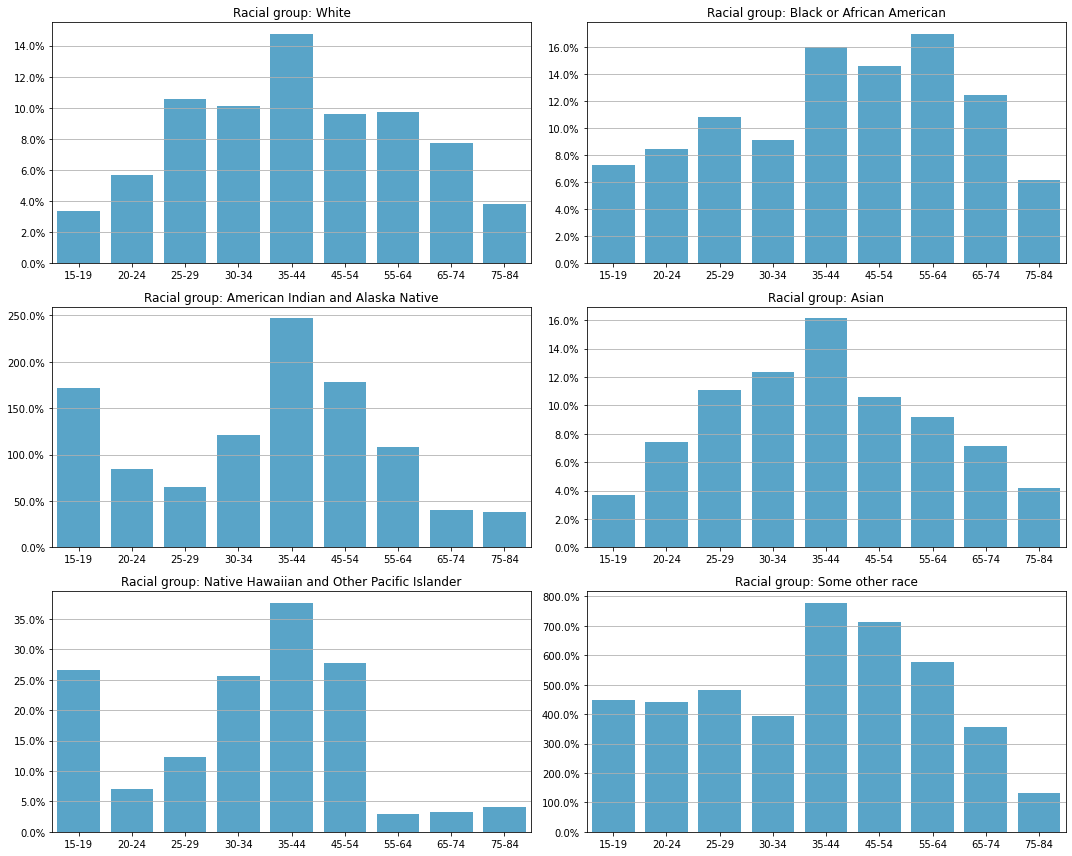

In [93]:
plt.rcParams['figure.figsize'] = [15, 12]
age_group = acs21_age_race.age_group.unique()

for i in range(len(acs21_race.race)):
    plt.subplot(3, 2 ,i+1)
    race = acs21_race.race[i]
    ax = sns.barplot(x = age_group, 
                     y = [prob_age_given_race(race, age)*100 for age in age_group], 
                     color = "#46abdb")
 #   plt.ylabel("Probability (%)")
    vals = ax.get_yticks()
    ax.set_yticklabels([str(round(x,3)) + "%" for x in vals])
    ax.grid(True, axis = "y")
    plt.title(f'Racial group: {race}')
plt.tight_layout()
plt.show()

In [83]:
from scipy.interpolate import CubicSpline, interp1d

In [80]:
interp1d(np.linspace(0,8, num = 9, endpoint=True), [prob_age_given_race("White", age) for age in age_group], kind='cubic')

In [111]:
(np.arange(0,9))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

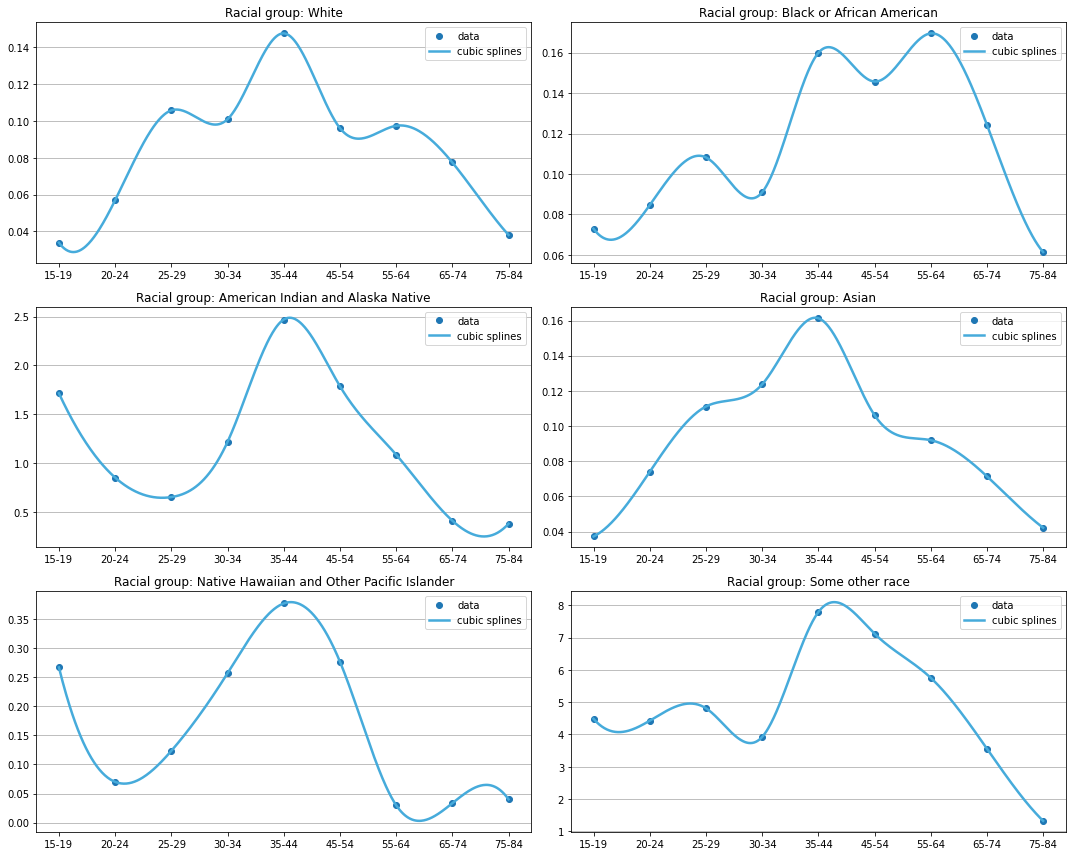

In [118]:
x_linear = np.arange(0,9)
plt.rcParams['figure.figsize'] = [15, 12]
age_group = acs21_age_race.age_group.unique()

for i in range(len(acs21_race.race)):
    plt.subplot(3, 2 ,i+1)
    race = acs21_race.race[i]
    y_prob = [prob_age_given_race(race, age) for age in age_group]
    cubic_interpolation_model = interp1d(x_linear, y_prob, kind = "cubic")
    x_new = np.linspace(0,8,500)
    plt.plot(age_group, y_prob, "o", label = "data")
    plt.plot(x_new,cubic_interpolation_model(x_new), label = "cubic splines", color = "#46abdb", linewidth=2.5)
    plt.legend(loc = "upper right")
    plt.grid(axis = 'y')
    plt.title(f'Racial group: {race}')
plt.tight_layout()
plt.show()

### Loading the ACS data

In [ ]:
acs_data = census_age.merge(census_race, how = "left", on = "Block Group" )
acs_data.head(5)

,Block Group,Total:_x,All: Under 5 years,All: 5 to 9 years,All: 10 to 14 years,All: 15 to 17 years,All: 18 and 19 years,All: 20 years,All: 21 years,All: 22 to 24 years,...,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Two or more races,Hispanic or Latino,BG_Block_Group_num_y,BG_Census Tract_y,BG_County_y,BG_State_y
0,"Block Group 1, Census Tract 3018.01, Cook Coun...",1933,396,82,312,59,45,0,0,75,...,0,0,0,0,14,1886,1,3018.01,Cook County,Illinois
1,"Block Group 2, Census Tract 3018.02, Cook Coun...",1238,26,193,155,90,59,24,21,36,...,0,0,0,0,0,1191,2,3018.02,Cook County,Illinois
2,"Block Group 2, Census Tract 3018.03, Cook Coun...",1606,147,131,92,15,0,23,0,102,...,0,0,0,0,0,1606,2,3018.03,Cook County,Illinois
3,"Block Group 2, Census Tract 3102, Cook County,...",1009,83,40,31,14,0,0,0,23,...,0,135,0,0,6,445,2,3102.00,Cook County,Illinois
4,"Block Group 1, Census Tract 3105, Cook County,...",1434,107,70,86,22,16,0,17,109,...,0,7,0,0,0,1148,1,3105.00,Cook County,Illinois


In [ ]:
acs_data.iloc[:, [5,6]].sum()

All: 15 to 17 years     188610
All: 18 and 19 years    121506
dtype: int64

In [ ]:
acs_data.columns

Index(['Block Group', 'Total:_x', 'All: Under 5 years', 'All: 5 to 9 years',
       'All: 10 to 14 years', 'All: 15 to 17 years', 'All: 18 and 19 years',
       'All: 20 years', 'All: 21 years', 'All: 22 to 24 years',
       'All: 25 to 29 years', 'All: 30 to 34 years', 'All: 35 to 39 years',
       'All: 40 to 44 years', 'All: 45 to 49 years', 'All: 50 to 54 years',
       'All: 55 to 59 years', 'All: 60 and 61 years', 'All: 62 to 64 years',
       'All: 65 and 66 years', 'All: 67 to 69 years', 'All: 70 to 74 years',
       'All: 75 to 79 years', 'All: 80 to 84 years', 'All: 85 years and over',
       'BG_Block_Group_num_x', 'BG_Census Tract_x', 'BG_County_x',
       'BG_State_x', 'Total:_y', 'Not Hispanic or Latino', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Two or more races', 'Hispanic or Latino',
       'BG_Block_Group_num_y', 'BG_Census Tract_y', 'BG_Co

### Parsing table from the Secretary of State pdf

In [ ]:
sos_data.head(10)

,AGE,MALE,FEMALE,TOTAL,YEAR
0,15 & Younger,32970,34029,66999,2019
1,16,59171,60321,119492,2019
2,17,64897,65122,130019,2019
3,18,68861,66440,135301,2019
4,19,72495,69046,141541,2019
5,20,74848,70052,144900,2019
6,21,67926,65824,133750,2019
7,22,72222,69236,141458,2019
8,23,77481,74764,152245,2019
9,24,82995,80028,163023,2019


In [ ]:
sos_21 = sos_data[sos_data.loc[:, "YEAR"] == 2021].iloc[1:,:]
sos_21 = sos_21.astype({"AGE": "int"})
sos_21 = sos_21[sos_21.AGE < 85]

In [ ]:
sos_21.loc[:,"SHARE"] = sos_21.TOTAL/sos_21.TOTAL.sum()

Share is P(Driver, Age = x): the distribution of drivers' age



In [ ]:
sos_21 = sos_21.reset_index()
sos_21 = sos_21.iloc[:,1:]
sos_21.head(5)

,AGE,MALE,FEMALE,TOTAL,YEAR,SHARE
0,16,55600,55958,111558,2021,0.012742
1,17,62332,61865,124197,2021,0.014186
2,18,65644,63481,129125,2021,0.014749
3,19,68759,65467,134226,2021,0.015331
4,20,72707,69039,141746,2021,0.016190


In [ ]:
sos_21.sort_values(by = "SHARE", ascending=False) # look at max and min values

,AGE,MALE,FEMALE,TOTAL,YEAR,SHARE
9,25,83519,80764,164283,2021,0.018765
13,29,82944,80883,163827,2021,0.018712
17,33,82022,80589,162611,2021,0.018574
16,32,80240,80121,160361,2021,0.018317
25,41,79041,80032,159073,2021,0.018169
...,...,...,...,...,...,...
64,80,21684,23733,45417,2021,0.005188
65,81,18630,20176,38806,2021,0.004432
66,82,16746,18315,35061,2021,0.004005
67,83,14145,15471,29616,2021,0.003383


In [ ]:
sos_21.dtypes

AGE         int64
MALE        int64
FEMALE      int64
TOTAL       int64
YEAR        int64
SHARE     float64
dtype: object

In [ ]:
num_driver = sum(sos_21.iloc[:,-3])
num_driver

8754982

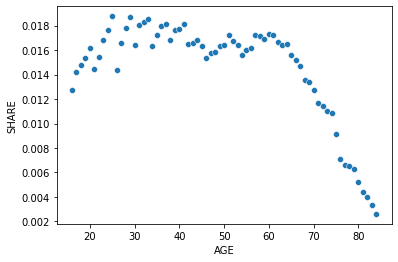

In [ ]:
sns.scatterplot(data=sos_21, x = "AGE", y = "SHARE")